In [40]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import folium
import time

In [41]:
class KMeansClustering:
    def __init__(self, file_path, k=3):
        """
        Initialize the KMeansClustering class.
        :param file_path: Path to the CSV file containing the data.
        :param k: Number of clusters for KMeans.
        """
        self.spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()
        self.file_path = file_path
        self.k = k

    def load_data(self):
        """
        Load the data from the CSV file into a Spark DataFrame.
        :return: Spark DataFrame containing the data.
        """
        start_time = time.time()
        df = self.spark.read.csv(self.file_path, header=True, inferSchema=True)
        self.data_loading_time = time.time() - start_time
        return df

    def preprocess_data(self, df):
        """
        Preprocess the data by assembling features and scaling.
        :param df: Spark DataFrame with raw data.
        :return: Spark DataFrame with scaled features.
        """
        assembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
        df = assembler.transform(df)
        scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)
        return df

    def fit_kmeans(self, df):
        """
        Fit KMeans clustering model and return the DataFrame with predictions.
        :param df: Spark DataFrame with scaled features.
        :return: Spark DataFrame with cluster predictions.
        """
        start_time = time.time()
        kmeans = KMeans(k=self.k, seed=42, featuresCol="scaled_features", predictionCol="prediction")
        model = kmeans.fit(df)
        df_with_predictions = model.transform(df)
        self.clustering_time = time.time() - start_time
        return df_with_predictions

    def get_data_loading_time(self):
        """
        Get the time taken to load data.
        :return: Data loading time in seconds.
        """
        return self.data_loading_time

    def get_clustering_time(self):
        """
        Get the time taken to perform clustering.
        :return: Clustering time in seconds.
        """
        return self.clustering_time


In [42]:
def plot_clusters(df_pd):
    """
    Plot the clusters of user data on a scatter plot.
    :param df_pd: Pandas DataFrame containing latitude, longitude, and cluster predictions.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df_pd['Longitude'], df_pd['Latitude'], c=df_pd['prediction'], cmap='viridis', alpha=0.6, s=10)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('KMeans Clustering of User Data')
    plt.colorbar(label='Cluster')
    plt.show()


def plot_elbow_method(df):
    """
    Plot the elbow method for determining the optimal number of clusters.
    :param df: DataFrame with features to be clustered.
    """
    wcss = []
    for i in range(2, 11):  # Start from 2 to avoid invalid k values
        kmeans = KMeans(k=i, seed=42)
        
        # Create a new DataFrame for each KMeans fit to avoid column conflicts
        if 'prediction' in df.columns:
            df_temp = df.drop("prediction")
        else:
            df_temp = df
        
        # Fit KMeans model
        model = kmeans.fit(df_temp)
        
        # Append WCSS (Within-Cluster Sum of Squares)
        wcss.append(model.summary.trainingCost)
    
    # Plot the Elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, 11), wcss, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal k')
    plt.show()



In [43]:
def create_map(df_pd, clusters):
    """
    Create and display a map with cluster markers.
    :param df_pd: Pandas DataFrame containing latitude, longitude, and cluster predictions.
    :param clusters: List of clusters, where each cluster is a list of latitude and longitude pairs.
    :return: Folium map object with cluster markers.
    """
    map = folium.Map(location=[df_pd['Latitude'].mean(), df_pd['Longitude'].mean()], zoom_start=10, 
                     tiles="openstreetmap")
    colors = ['blue', 'red', 'green']
    for i, cluster in enumerate(clusters):
        for row in cluster:
            folium.CircleMarker(
                location=[row['Latitude'], row['Longitude']],
                radius=2,
                color=colors[i],
                fill=True,
                fill_color=colors[i],
                fill_opacity=0.6
            ).add_to(map)
    return map


Data Loading Time: 0.11 seconds
Clustering Time: 0.94 seconds


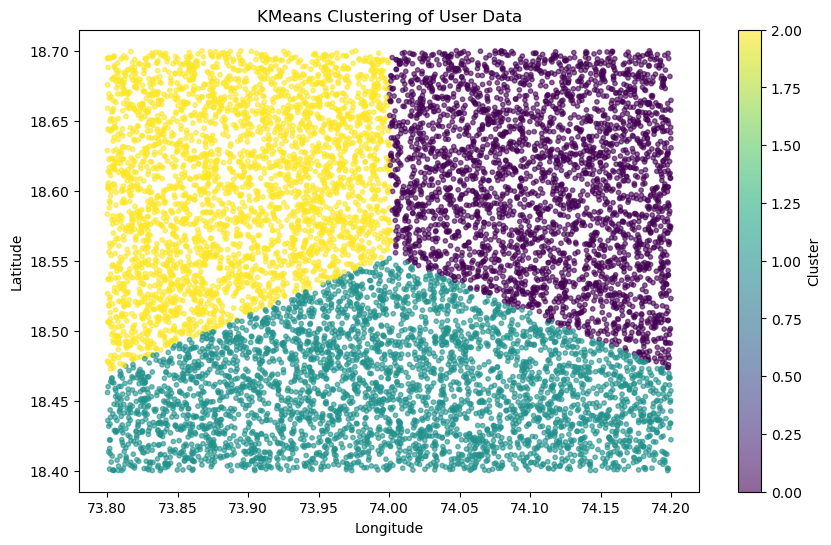

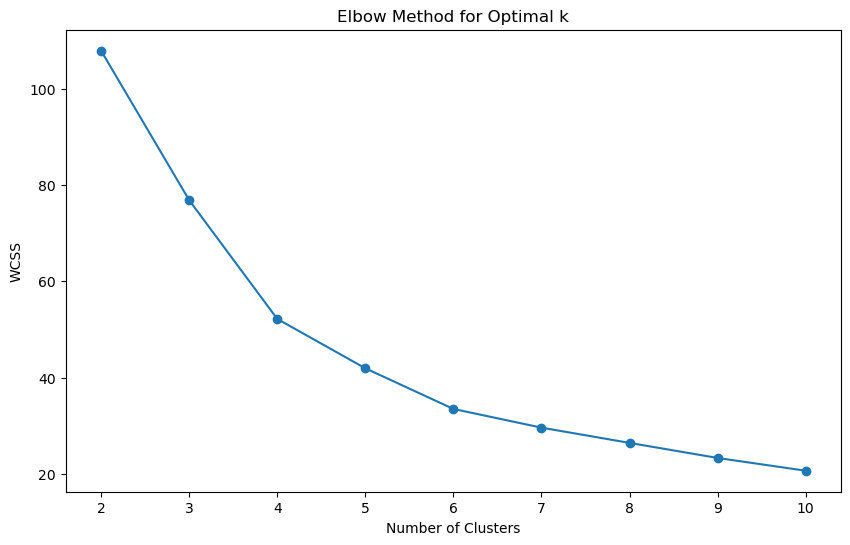

In [44]:
# Load the data and run KMeans clustering
file_path = "unique.csv" 
clustering = KMeansClustering(file_path, k=3)
df = clustering.load_data()
df = clustering.preprocess_data(df)
df_with_predictions = clustering.fit_kmeans(df)

# Convert to Pandas DataFrame for plotting
df_pd = df_with_predictions.select("Latitude", "Longitude", "prediction").toPandas()

# Print times
print(f"Data Loading Time: {clustering.get_data_loading_time():.2f} seconds")
print(f"Clustering Time: {clustering.get_clustering_time():.2f} seconds")

# Plot results
plot_clusters(df_pd)
plot_elbow_method(df)

# Create and display the map
clusters = [df_with_predictions.filter(df_with_predictions['prediction'] == i).select("Latitude", "Longitude").collect() for i in range(3)]
map = create_map(df_pd, clusters)
map
